# Task 1, 3 - fastai interface to ingest models from model zoo

This notebook we see how fastai functions quite easily for data preparations, data augmentation, training and inference. We will also see how the model can be converted into model-agnostic `onnx` and further to tensorflow and compare the inferences using `onnxruntime`. Then we see how fastai can be used to quickly run functionality and comprehensibility analyses. Here we look at the example of classification of pet breeds. Task 4 is carried out throughout notebooks `01-pet-breed` and `02-tabular`.

In [1]:
from fastai.vision.all import *

## 1.1 - Set data loading params

In [2]:
path = untar_data(URLs.PETS)/'images'
fnames = get_image_files(path)
pat = r'/([^/]+)_\d+.*'

In [3]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

We can set up a datablock with includes item and batch transformations. These lines implement a fastai data augmentation strategy which we call presizing. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

In [4]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [5]:
dls = pets.dataloaders(path,path=path, bs=bs)

In [6]:
dls.c # number of categories

37

With the dataloader, we can quickly using `show_batch` before training a model.

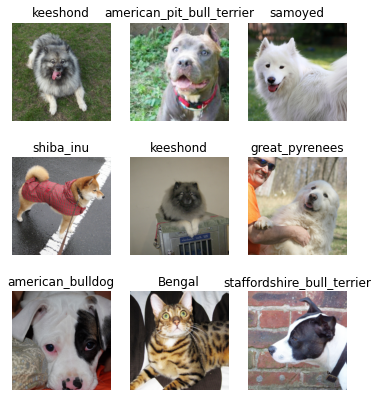

In [7]:
dls.show_batch(max_n=9, figsize=(6,7))

## 1.2 - Initialize learner model

In [8]:
learn = cnn_learner(dls, resnet18) # using fastai built-in model

Notice the learner model only works with head and body parts:

In [9]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

We can see that our fastai model was split into two different layer groups:

    Group 1: Our encoder, which is everything but the last layer of our original model
    Group 2: Our head, which is a fastai version of a Linear layer plus a few extra bits



## 1.3 - Get pretrained model

In [10]:
from timm import create_model

In [11]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_lite0',
 'ens_adv_inception_resnet_v2',
 'ese_vovnet19b_dw',
 'ese_vovnet39b',
 'fbnetc_100',
 'gluon_inception_v3',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resn

In [12]:
net = create_model('resnet18', pretrained=True) #load pretrained models elsewhere

In [13]:
net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                          6.6221

The model from pytorch only has the head, not the body. Learner interface needs both head and body. 

In [14]:
def create_timm_body(arch:str, pretrained=True, cut=None):
    model = create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [15]:
body = create_timm_body('resnet18',pretrained=True)

In [16]:
body

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU

In [17]:
nf = num_features_model(nn.Sequential(*body.children())) * (2); nf

1024

In [18]:
head = create_head(nf, dls.c)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In [19]:
model = nn.Sequential(body, head) # fastai Learner needs body and head

In [20]:
apply_init(model[1], nn.init.kaiming_normal_)

In [21]:
len(model) # Now we have head and body

2

Great! Now we have both the body commonly received from pretrained model zoos, as well as the head for fastai use. Fastai already allows comfortable imports of these pretrained architectures, in case we have other models we want to use, we can edit them through this way.

In [22]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy())

In [23]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d       

The new model is not frozen, we need to split the model to model[0] (head) and model[1] body - we `use default_split` for this purpose:

In [24]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=error_rate,
               path=path)

In [25]:
learn.freeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d       

Now we find the optimal learning rate, which is roughly at the steepest slope:

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.002511886414140463)

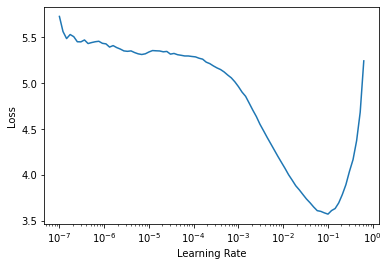

In [26]:
learn.lr_find()

Now we can train our model using the suitable learning rate:

In [27]:
learn.fit_one_cycle(5, slice(3e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.892079,1.660377,0.196211,00:47
1,1.444897,1.108675,0.121110,00:47
2,1.157511,1.026716,0.086604,00:48
3,1.029567,0.972929,0.077808,00:49
4,0.963642,0.955414,0.073748,00:49


We can use fastai learner to save at the path:

In [28]:
learn.save('cat-0')

Path('/home/hud/.fastai/data/oxford-iiit-pet/images/models/cat-0.pth')

## 1.4 - Convert fastai pytorch to ONNX

We export the fastai model to onnx and evaluate later.

In [29]:
learn.model.eval();
torch.onnx.export(
    learn.model,
    torch.randn(1, 3, 224, 224).cuda(),
    path/"models/pet-breed.onnx",
    input_names=["image"],
    output_names=["breeds"]
)

# Task 5 - Use model-agnostic ONNX runtime for classification

In [30]:
import onnxruntime as rt
import numpy as np

In [31]:
sess = rt.InferenceSession("/home/hud/.fastai/data/oxford-iiit-pet/images/models/pet-breed.onnx")

In [32]:
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
input_name, label_name

('image', 'breeds')

In [33]:
# run once
!wget https://raw.githubusercontent.com/onnx/onnx-docker/master/onnx-ecosystem/inference_demos/images/dog.jpg

--2020-12-18 14:55:54--  https://raw.githubusercontent.com/onnx/onnx-docker/master/onnx-ecosystem/inference_demos/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.68.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.68.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21240 (21K) [image/jpeg]
Saving to: ‘dog.jpg.2’

dog.jpg.2           100%[===================>]  20.74K  --.-KB/s    in 0s      

2020-12-18 14:55:55 (46.8 MB/s) - ‘dog.jpg.2’ saved [21240/21240]



Image size:  (224, 224)


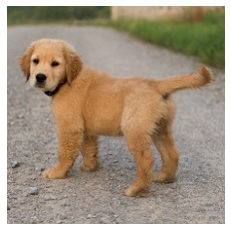

In [35]:
image = PILImage.create(f'dog.jpg')

print("Image size: ", image.size)
plt.axis('off')
display_image = plt.imshow(image)
image_data = np.array(image).transpose(2, 0, 1)
input_data = preprocess(image_data)

In [36]:
start = time.time()
raw_result = sess.run([label_name], {input_name: input_data})
end = time.time()
res = postprocess(raw_result)

Final top prediction is: great_pyrenees
Inference time: 29.31 ms
============ Top 5 labels are: ============================
['great_pyrenees', 'english_cocker_spaniel', 'wheaten_terrier', 'pomeranian', 'miniature_pinscher']


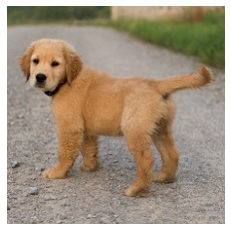

In [37]:
inference_time = np.round((end - start) * 1000, 2)
idx = np.argmax(res)

print('========================================')
print('Final top prediction is: ' + dls.vocab[idx])
print('========================================')

print('========================================')
print('Inference time: ' + str(inference_time) + " ms")
print('========================================')

sort_idx = np.flip(np.squeeze(np.argsort(res)))
print('============ Top 5 labels are: ============================')
print(dls.vocab[sort_idx[:5]])
print('===========================================================')

plt.axis('off')
display_image = plt.imshow(image)

Let's see how that compares with fastai inference

In [38]:
start = time.time()
fastai_res = learn.predict(image, with_input=False)
end = time.time()
inference_time = np.round((end - start) * 1000, 2)
print('Inference time: ' + str(inference_time) + " ms")
fastai_res

Inference time: 47.38 ms


('great_pyrenees',
 tensor(21),
 tensor([0.0123, 0.0092, 0.0038, 0.0142, 0.0149, 0.0164, 0.0035, 0.0077, 0.0051,
         0.0086, 0.0121, 0.0041, 0.0021, 0.0122, 0.0285, 0.0983, 0.0016, 0.0138,
         0.1326, 0.0097, 0.0055, 0.3158, 0.0260, 0.0142, 0.0032, 0.0283, 0.0454,
         0.0158, 0.0357, 0.0153, 0.0029, 0.0040, 0.0041, 0.0228, 0.0040, 0.0369,
         0.0095]))

Great ! ONNX-runtime classifies the one of the top 5 dog breed but beats the fastai inference by about 15 ms!

## ONNX-tensorflow for deployment

In [39]:
import onnx
from onnx_tf.backend import prepare
import warnings
warnings.filterwarnings('ignore')

# Load the ONNX file
model = onnx.load("/home/hud/.fastai/data/oxford-iiit-pet/images/models/pet-breed.onnx")

# Import the ONNX model to Tensorflow
tf_rep = prepare(model)

# Export Tensorflow model
tf_rep.export_graph(path/'models/pet-breed.pb')

output = tf_rep.run(np.asarray(input_data, dtype=np.float32)[:, :])
print('The dog is classified as ',labels[np.argmax(output)])




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/hud/Documents/coding-challenge/onnx-tensorflow/onnx_tf/common/__init__.py:107: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


The dog is classified as  great_pyrenees


Super! Now we have shown pytorch-based fastai->ONNX->tensorflow conversions with similar inferences. Let's move on to further analysis.

# Task 2 - Further analysis

## 2.1 - Functionality

So we have reduced our loss functions, as evident from the `error_rate` metric but how should we interpret the model - where are we making mistakes?

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.load('cat-0');

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

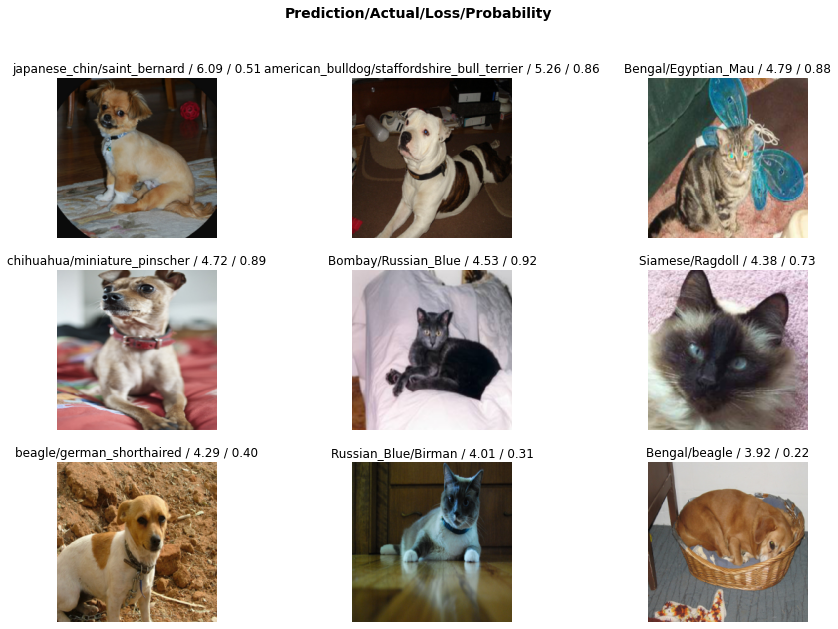

In [45]:
interp.plot_top_losses(9, figsize=(15,10))

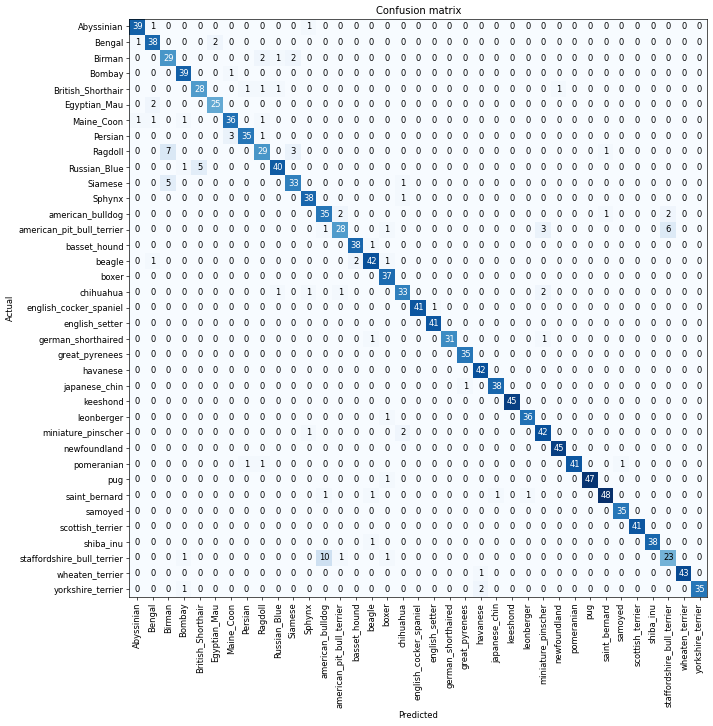

In [46]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Well, in this case, a confusion matrix is very hard to read. We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the most_confused method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 3 or more):

In [47]:
interp.most_confused(min_val=3)

[('staffordshire_bull_terrier', 'american_bulldog', 10),
 ('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('Siamese', 'Birman', 5),
 ('Persian', 'Maine_Coon', 3),
 ('Ragdoll', 'Siamese', 3),
 ('american_pit_bull_terrier', 'miniature_pinscher', 3)]

## 2.2 - Comprehensibility

We want to see what the model sees to identify whether something is a cat or a dog. So we look at the Class Activation Map (CAM) functionality to give us insight into why the CNN made the predictions that it did - here we look at the cat instance.

In [48]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.127736,0.025160,0.008796,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.060159,0.010761,0.003383,01:32


In [49]:
learn.save('cam-1')

Path('/home/hud/.fastai/data/oxford-iiit-pet/images/models/cam-1.pth')

In [50]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.model.cuda()
learn.load('cam-1');

In [51]:
!wget https://www.mynorthridgevet.com/imagebank/eVetSites/DogCats/052016_EVS_CatDog5.jpg

--2020-12-18 14:59:01--  https://www.mynorthridgevet.com/imagebank/eVetSites/DogCats/052016_EVS_CatDog5.jpg
Resolving www.mynorthridgevet.com (www.mynorthridgevet.com)... 67.159.202.100
Connecting to www.mynorthridgevet.com (www.mynorthridgevet.com)|67.159.202.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17211 (17K) [image/jpeg]
Saving to: ‘052016_EVS_CatDog5.jpg.1’

052016_EVS_CatDog5. 100%[===================>]  16.81K  --.-KB/s    in 0.004s  

2020-12-18 14:59:01 (4.38 MB/s) - ‘052016_EVS_CatDog5.jpg.1’ saved [17211/17211]



In [52]:
img = PILImage.create(f'052016_EVS_CatDog5.jpg')
x, = first(dls.test_dl([img]))

One way to access the activations inside the model while training is through hooks. Hooks are PyTorch's equivalent of fastai's callbacks. However, rather than allowing you to inject code into the training loop like a fastai Learner callback, hooks allow you to inject code into the forward and backward calculations themselves. We can attach a hook to any layer of the model, and it will be executed when we compute the outputs (forward hook) or during backpropagation (backward hook). 

In [53]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [54]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

In [55]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [56]:
cls = 1
with HookBwd(learn.model[0]) as hookg: # average of all layers
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [62]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

torch.Size([14, 14])

For instance, we can find out which areas made the model decide this animal was a cat:

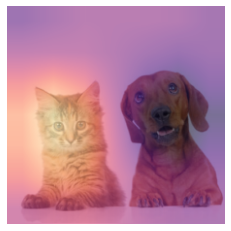

In [58]:
_,ax = plt.subplots()
x_dec = TensorImage(dls.train.decode((x,))[0][0])
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

The novelty with Grad-CAM is that we can use it on any layer. For example, here we use it on the output of the second-to-last ResNet group:

In [59]:
with HookBwd(learn.model[0][-2]) as hookg: # 
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [60]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

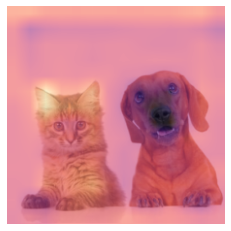

In [61]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

## Task 5 cont'd Discussion

From the perspective of layman without fundamental background in computer science, the biggest hurdle to continue learning how to approach different analyses for different models is to find active and growing community beyond stackoverflow to support their endeavours. Fastai is one such community with good code maintenance and a very active forum.

My understanding is that pytorch-based frameworks are good for research but would eventually need to be converted to tensorflow/keras for deployment, for which I have used onnx here. In my ONNX is future of model interoperability and useful for edge devices, but it is still in its infant stage that I had difficulty finding deeper functionality and comprehensibility beyond just inferences and predictions.

In fact, for computer vision, there's still a lot of reported accuracy mismatch when comparing onnx inferences due to images not being normalized, how images are resized eg PIL or cv2, resampling methods, to name a few. Further reading shows the subtle differences of how layers are handled between pytorch and tensorflow eg different padding, also contributes to differences. I anticipate that the growth of edge devices will drive a larger community to be more model-agnostic. 